### Testing Evo

#### Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch_geometric
from torch_geometric.nn import GCNConv
import IPython
from IPython.display import display, HTML, Image
from torch_geometric.loader import DataLoader

from graphUtils import add_edges
from generator import generate_organism
from cell import Cell
from organism import Organism
from GNCAmodel import GNCA
from visualizer import Visualizer
from evo_trainer import Evo_Trainer

#%run Visualizer.py # --allows for reloading the particular code

#### Train the network

In [2]:
n = 5
popsize = 20
generations = 500
batch_size = 16
wrap_around = True
name = 'centered8'
#device = torch.device('mps:0')
device = torch.device('cpu')
#trainer = Evo_Trainer(n, device)
trainer = Evo_Trainer(n, device, batch_size, True, popsize)

2023-02-28 22:26:14,155	INFO worker.py:1528 -- Started a local Ray instance.


[2023-02-28 22:26:16] INFO     <85603> evotorch.core: Instance of `Custom_NEProblem` (id:4376601712) -- The `dtype` for the problem's decision variables is set as torch.float32
[2023-02-28 22:26:16] INFO     <85603> evotorch.core: Instance of `Custom_NEProblem` (id:4376601712) -- `eval_dtype` (the dtype of the fitnesses and evaluation data) is set as torch.float32
[2023-02-28 22:26:16] INFO     <85603> evotorch.core: Instance of `Custom_NEProblem` (id:4376601712) -- The `device` of the problem is set as cpu
[2023-02-28 22:26:16] INFO     <85603> evotorch.core: Instance of `Custom_NEProblem` (id:4376601712) -- The number of actors that will be allocated for parallelized evaluation is 10
[2023-02-28 22:26:16] INFO     <85603> evotorch.core: Instance of `Custom_NEProblem` (id:4376601712) -- Number of GPUs that will be allocated per actor is None


/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/evotorch/tools/misc.py:1107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = torch.tensor(data, **kwargs)


In [3]:
trainer.train(generations, name)

         iter : 1
     stepsize : ReadOnlyTensor(0.0984)
  median_eval : 37.0
    mean_eval : 36.95000076293945
pop_best_eval : 43.0

         iter : 2
     stepsize : ReadOnlyTensor(0.0970)
  median_eval : 34.0
    mean_eval : 33.95000076293945
pop_best_eval : 40.0

         iter : 3
     stepsize : ReadOnlyTensor(0.0957)
  median_eval : 45.0
    mean_eval : 44.849998474121094
pop_best_eval : 53.0

         iter : 4
     stepsize : ReadOnlyTensor(0.0945)
  median_eval : 33.0
    mean_eval : 33.900001525878906
pop_best_eval : 44.0

         iter : 5
     stepsize : ReadOnlyTensor(0.0934)
  median_eval : 48.0
    mean_eval : 47.54999923706055
pop_best_eval : 53.0

         iter : 6
     stepsize : ReadOnlyTensor(0.0924)
  median_eval : 39.0
    mean_eval : 39.0
pop_best_eval : 47.0

         iter : 7
     stepsize : ReadOnlyTensor(0.0915)
  median_eval : 40.0
    mean_eval : 40.5
pop_best_eval : 50.0

         iter : 8
     stepsize : ReadOnlyTensor(0.0906)
  median_eval : 37.0
    mean

In [4]:
network = trainer.get_trained_network()

In [5]:
#network = trainer.problem.parameterize_net(trainer.searcher.status['best'][0])
network = trainer.problem.parameterize_net(trainer.searcher.status['center'][0])
#network = trainer.problem.parameterize_net(trainer.searcher.status['obj0_pop_best'])
#network = trainer.problem.parameterize_net(trainer.searcher.status['obj4_pop_best'])

In [6]:
#trainer.searcher.status

#### Visualize trained network

In [7]:
graphs = [generate_organism(n, device).toGraph() for _ in range(1)]
loader = DataLoader(graphs, batch_size=2)
graph = next(iter(loader))
visualizer = Visualizer(wrap_around)
network.batch_size = 1
network(graph, 0)

DataBatch(x=[55, 5], edge_index=[1, 0], device=[1], subsize=[1], energy=[1], velocity=[1], border_cost=[1], food_reward=[1], dead_cost=[1], visible_food=[1], food_avg_dist=[1], food_avg_degree=[1], batch=[55], ptr=[2])

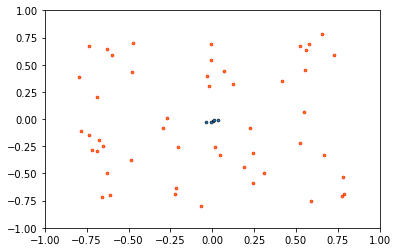

In [8]:
anim = visualizer.animate_organism(graph, network, food=30, frames=200)
visualizer.save_animation_to_gif(anim, name, 10)

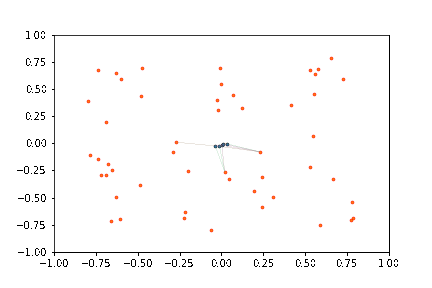

In [9]:
Image('../animation/' + name + '.gif')

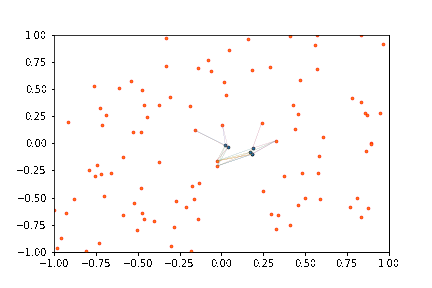

In [10]:
Image('../animation/GATConv1.gif')

In [11]:
anim.frame_seq = anim.new_saved_frame_seq() 
IPython.display.HTML(anim.to_jshtml())

In [12]:
print(network)

CGConv1(
  (conv_layer_cells): CGConv(4, dim=4)
  (conv_layer_food): CGConv(4, dim=4)
  (mlp_before): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): Tanh()
  )
  (mlp_middle): Sequential(
    (0): Tanh()
    (1): Linear(in_features=8, out_features=4, bias=True)
    (2): Tanh()
  )
  (mlp): Sequential(
    (0): Tanh()
    (1): Linear(in_features=4, out_features=2, bias=True)
    (2): Tanh()
  )
  (gConvGRU): GConvGRU(
    (conv_x_z): ChebConv(4, 4, K=1, normalization=sym)
    (conv_h_z): ChebConv(4, 4, K=1, normalization=sym)
    (conv_x_r): ChebConv(4, 4, K=1, normalization=sym)
    (conv_h_r): ChebConv(4, 4, K=1, normalization=sym)
    (conv_x_h): ChebConv(4, 4, K=1, normalization=sym)
    (conv_h_h): ChebConv(4, 4, K=1, normalization=sym)
  )
)


In [13]:
print('conv_layers1: ', network.conv_layer_cells)
for param in network.conv_layer_cells.parameters():
  print(param.data)

print('conv_layers2: ', network.conv_layer_food)
for param in network.conv_layer_food.parameters():
  print(param.data)

conv_layers1:  CGConv(4, dim=4)
tensor([[ 0.5353, -0.0295,  0.3986,  0.1652, -0.5084,  0.7549,  0.5033,  0.3836,
          0.2568, -0.0141,  0.3664, -0.1646],
        [-0.9024,  0.9778, -0.1234, -0.3854,  0.7946, -0.7305, -0.8981,  0.7391,
          0.5814,  0.2100,  0.0477,  0.1561],
        [ 0.5276, -0.4965,  0.0867, -1.1485, -0.3478,  1.0915,  0.3885, -0.0102,
          0.2385,  0.1043,  0.1909,  0.1603],
        [ 0.7112,  0.0173, -0.4052, -0.4702,  0.2016, -0.5709,  0.0755, -0.1868,
         -0.5105,  0.1323,  0.2344, -0.4236]])
tensor([ 0.0369, -0.6643, -0.5155,  0.2056])
tensor([[ 0.4289,  0.1554,  0.4215, -0.2744, -0.6022,  0.1745,  0.1234, -0.0685,
         -0.4615, -0.5950,  0.2174, -0.1075],
        [ 0.2598,  0.0594,  0.3107, -0.1800,  0.4061, -0.0564, -0.0898, -0.1187,
         -0.4095, -0.3323, -0.4516, -0.2778],
        [ 0.2075, -0.6639, -0.2535, -0.8193, -0.5322,  0.9131, -0.1651,  0.1063,
         -0.5779, -0.2369,  0.3111, -0.0867],
        [-0.2630, -1.1059, -0.287

In [14]:
print('GConvGRU: ', network.gConvGRU)
for param in network.gConvGRU.parameters():
  print(param.data)


GConvGRU:  GConvGRU(
  (conv_x_z): ChebConv(4, 4, K=1, normalization=sym)
  (conv_h_z): ChebConv(4, 4, K=1, normalization=sym)
  (conv_x_r): ChebConv(4, 4, K=1, normalization=sym)
  (conv_h_r): ChebConv(4, 4, K=1, normalization=sym)
  (conv_x_h): ChebConv(4, 4, K=1, normalization=sym)
  (conv_h_h): ChebConv(4, 4, K=1, normalization=sym)
)
tensor([-0.0147,  0.1535,  0.2422, -0.6029])
tensor([[-0.3973, -0.1477, -0.0319,  0.0377],
        [ 0.2748,  0.3402, -0.6094, -0.1790],
        [ 0.3136, -0.0227,  0.3759,  0.5195],
        [ 0.1199, -0.0512, -0.0617,  0.3628]])
tensor([ 0.3926, -0.3665,  0.2702, -0.1622])
tensor([[-0.8732,  0.1615,  0.2150, -0.5870],
        [-0.0143, -0.3067, -0.0914,  0.1832],
        [-0.3341, -0.3066,  0.6229,  0.2588],
        [ 0.2431,  0.4936, -0.5480,  0.8660]])
tensor([-0.8652,  0.2356,  0.6646, -0.2826])
tensor([[ 0.2291,  0.4260, -0.7078,  0.1483],
        [ 0.3642,  0.4259,  0.0732,  0.1086],
        [ 0.9271,  0.1143,  0.6472,  0.2377],
        [-0.3447

In [15]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

#### Visualization of loss:

In [16]:
import matplotlib.pyplot as plt
losses = trainer.logger_df
print(losses)
#plt.plot(losses.stepsize)

#plt.plot(losses.median_eval)
#plt.plot(losses.pop_best_eval)
#plt.plot(losses.mean_eval)
#plt.legend(('median_eval', 'pop_best_eval', 'mean eval'))
plt.show()

                    stepsize  median_eval  mean_eval  pop_best_eval
iter                                                               
1     ReadOnlyTensor(0.0984)         37.0  36.950001           43.0
2     ReadOnlyTensor(0.0970)         34.0  33.950001           40.0
3     ReadOnlyTensor(0.0957)         45.0  44.849998           53.0
4     ReadOnlyTensor(0.0945)         33.0  33.900002           44.0
5     ReadOnlyTensor(0.0934)         48.0  47.549999           53.0
...                      ...          ...        ...            ...
196   ReadOnlyTensor(0.0730)         36.0  36.900002           45.0
197   ReadOnlyTensor(0.0731)         35.0  36.400002           48.0
198   ReadOnlyTensor(0.0731)         42.0  42.900002           54.0
199   ReadOnlyTensor(0.0732)         35.0  35.450001           44.0
200   ReadOnlyTensor(0.0732)         45.0  45.099998           54.0

[200 rows x 4 columns]


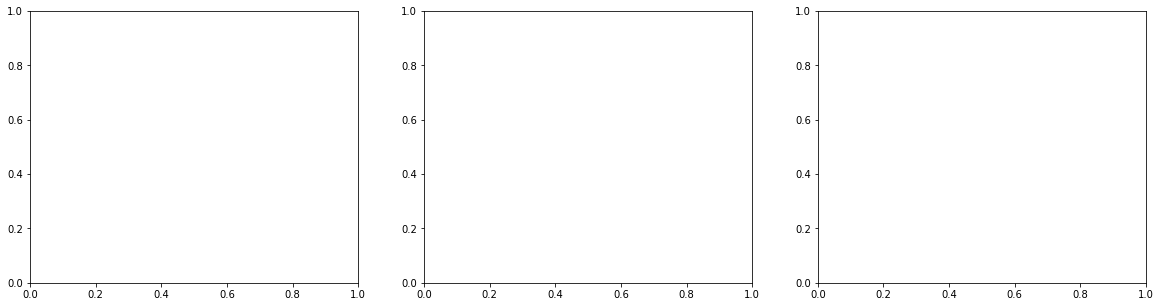

In [17]:
trainer.logger_df
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
fig.suptitle('')
plt.show()